<a href="https://colab.research.google.com/github/joheras/MusicaCatedralStoDomingoIER/blob/main/Notebooks/SacarM%C3%BAsica/image2xml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# input.jpg $\rightarrow$ output.xml
### Cuaderon para transformar las predicciones al formato musicxml

## Librerías

In [1]:
%%capture
pip install py_midicsv

In [2]:
%%capture
pip install MIDIUtil

In [3]:
%%capture
pip install pretty_midi

In [4]:
%%capture
!pip install icevision[all]==0.5.1

In [5]:
%%capture
!pip install torchtext==0.8.1

In [6]:
%%capture
!pip install fastai --upgrade

In [7]:
%%capture
!sudo apt install tesseract-ocr
!sudo apt-get install tesseract-ocr-spa
!pip install pytesseract
!pip install tesseract

In [ ]:
from icevision.all import *
from fastai.vision.all import *
import cv2
import pickle
import midiutil
import pretty_midi
from pytesseract import Output
import pytesseract
import IPython.display as ipd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import colors
import statistics
import py_midicsv as pm
import random
import operator
import pickle
import sys
import os
import json
import music21 as m21

In [2]:
%%capture
!git clone https://github.com/AlexeyAB/darknet
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!/usr/local/cuda/bin/nvcc --version
!make
!apt-get install tree
%cd ..

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Dataset y funciones

In [83]:
%%capture
!wget https://www.dropbox.com/s/u2ekoltvu35kfjw/Fotos.zip?dl=1 -O Fotos.zip
!wget https://www.dropbox.com/s/82mtx7r0jobjfru/datasetYOLO.zip?dl=1 -O datasetYOLO.zip
!wget https://www.dropbox.com/s/j1u7srq5xzg5mz5/efficientdet.pth?dl=1 -O efficientdet.pth
!wget https://www.dropbox.com/s/500gg680wejxe1y/faster.pth?dl=1 -O faster.pth
!wget https://www.dropbox.com/s/lxfhoh1v3skubil/RetinaNet.pth?dl=1 -O RetinaNet.pth
!wget https://www.dropbox.com/s/9p53walw9h2j0ws/train_last.weights?dl=1 -O train_last.weights
!wget https://www.dropbox.com/s/gs6eg6z3ydk5yel/export.pkl?dl=1 -O export.pkl
!unzip Fotos.zip
!unzip datasetYOLO.zip

In [84]:
with open("Obras_final.pickle", "rb") as f:
    Obras_final = pickle.load(f)
with open("ini_Obras.pickle", "rb") as f:
    ini_Obras = pickle.load(f)

In [85]:
def mostrarImagen(img):
  fig, ax = plt.subplots(1,1,figsize=(16,16))
  ax.imshow(img,cmap=plt.cm.binary)
  ax.axis('off')
  ax.xaxis.set_ticklabels([])
  ax.yaxis.set_ticklabels([])
  plt.show()

In [86]:
import xml.etree.ElementTree as ET
from xml.dom import minidom


def prettify(elem):
    """Return a pretty-printed XML string for the Element.
    """
    rough_string = ET.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

- **Para devolver una lista con los símbolos musicales**

In [87]:
def get_iou(bb1, bb2):
  if bb1[0] < bb1[2] and bb1[1] < bb1[3] and bb2[0] < bb2[2] and bb2[1] < bb2[3]:
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])
    if x_right < x_left or y_bottom < y_top: return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    if 0 <= iou <= 1: return iou
    else: return 0
  else: return 0

In [88]:
def get_iou2(bb1, bb2):
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [89]:
def remove_notas(bboxs,labels,scores):
  n = len(bboxs)
  L = []
  for i in range(0,n):
    k = len(bboxs[i:])
    bb1 = bboxs[i]
    l1 = labels[i]
    s1 = scores[i]
    for j in range(0,k):
      bb2 = bboxs[i:][j]
      l2 = labels[i:][j]
      s2 = scores[i:][j]
      if bb1[2]-bb1[0] >= 55 and 'nota' in l1:
        L.append(i)
      elif get_iou(bb1, bb2) > 0.5 and 'nota' in l1 and 'nota' in l2:
        if l1 > l2:
          L.append(i+j)
        if l1 < l2:
          L.append(i)
        if l1 == l2 and get_iou(bb1, bb2) < 1:
          if s1 > s2:
            L.append(i+j)
          else:
            L.append(i)
  L = list(np.unique(L))
  b,l,s = [],[],[]
  for i in range(0,n):
    if not(i in L):
      b.append(bboxs[i])
      l.append(labels[i])
      s.append(scores[i])
  return b,l,s

In [90]:
d={'background':0,'claved':1, 'claves':2, 'clavef':3, 'nota1':4, 'nota2':5, 'nota4':6, 'nota1:2':7, 'nota1:4':8, 'notae':9, 'sos':10, 'bem':11, 'bec':12, 'sil0':13, 'sil1':14, 'sil2':15, 'sil1:2':16, 'sil1:4':17, '2x4':18, '3x4':19, '4x4':20, '6x8':21, 'punt':22, 'liga':23,'3':24,'line':25,'P2':26, 'nota1:8':27, 'cal':28, '3x2':29,'mf':30,'P1':31,'check':32,'3x8':33,'2x2':34}
d = {v: k for k, v in d.items()}

def unconvert(width, height, x, y, w, h):
    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)
    return [xmin,ymin,xmax,ymax]

def qsort(bboxs,labels,scores):
  if bboxs == []:
    return bboxs,labels,scores
  bbox = bboxs[0]
  label = labels[0]
  score = scores[0]
  n = len(labels[1:])
  bboxsL,labelsL,scoresL = qsort([b for b in bboxs[1:] if b[0] < bbox[0]],[labels[1:][i] for i in range(0,n) if bboxs[1:][i][0] < bbox[0]],[scores[1:][i] for i in range(0,n) if bboxs[1:][i][0] < bbox[0]])
  bboxsU,labelsU,scoresU = qsort([b for b in bboxs[1:] if b[0] >= bbox[0]],[labels[1:][i] for i in range(0,n) if bboxs[1:][i][0] >= bbox[0]],[scores[1:][i] for i in range(0,n) if bboxs[1:][i][0] >= bbox[0]])

  return bboxsL + [bbox] + bboxsU, labelsL + [label] + labelsU, scoresL + [score] + scoresU

def pent_image2pred(test,model='faster'):
  if type(test) == str: test = cv2.imread(test)
  Y,X,_=test.shape
  if model == 'yolo':
    L,labels,scores = [],[],[]
    cv2.imwrite('pred.jpg',test)
    with open('test.txt','w') as f:
      f.write('pred.jpg')
      f.close()
    !./darknet/darknet detector test datasetYOLO/classes.data datasetYOLO/train.cfg train_last.weights -ext_output -dont_show -out result.json < test.txt
    resultado=json.loads(open('result.json').read())
    for res in resultado:
      for objeto in res['objects']:
        coords = objeto['relative_coordinates']
        conf = objeto['confidence']
        label = objeto['class_id']+1
        x,y,h,w=coords['center_x'],coords['center_y'],coords['height'],coords['width']
        xmin, ymin, xmax, ymax= unconvert(X, Y, x, y, w, h)
        L.append([xmin,ymin,xmax,ymax])
        labels.append(label)
        scores.append(conf)
  else:
    if model == 'faster':
      infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=923), tfms.A.Normalize()])
      infer_ds = Dataset.from_images([test], infer_tfms)
      infer_dl = faster_rcnn.infer_dl(infer_ds, batch_size=1)
      samples, preds = faster_rcnn.predict_dl(model=faster, infer_dl=infer_dl)
    elif model == 'retina':
      infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=923), tfms.A.Normalize()])
      infer_ds = Dataset.from_images([test], infer_tfms)
      infer_dl = retinanet.infer_dl(infer_ds, batch_size=1)
      samples, preds = retinanet.predict_dl(model=retina, infer_dl=infer_dl)
    elif model == 'efficient':
      infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=512), tfms.A.Normalize()])
      infer_ds = Dataset.from_images([test], infer_tfms)
      infer_dl = efficientdet.infer_dl(infer_ds, batch_size=1)
      samples, preds = efficientdet.predict_dl(model=efficent, infer_dl=infer_dl)
    L = []
    labels = list(preds[0]['labels'])
    bboxs = preds[0]['bboxes']
    for i in range(0,len(labels)):
      xmin=bboxs[i].xmin
      ymin=bboxs[i].ymin-(samples[0]['img'].shape[0]-samples[0]['height'])/2
      xmax=bboxs[i].xmax
      ymax=bboxs[i].ymax-(samples[0]['img'].shape[0]-samples[0]['height'])/2
      xmin=int(X*xmin/samples[0]['width'])
      ymin=int(Y*ymin/samples[0]['height'])
      xmax=int(X*xmax/samples[0]['width'])
      ymax=int(Y*ymax/samples[0]['height'])
      L.append([xmin,ymin,xmax,ymax])
    scores = list(preds[0]['scores'])
  L,labels,scores = qsort(L,labels,scores)
  labels = [d[l] for l in labels]
  return remove_notas(L,labels,scores)

In [91]:
def image2data(Obra,model='faster'):
  data = {}
  Y,X,_=Obra.shape
  aux = borrar_texto(Obra)
  gray = cv2.cvtColor(aux,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  dilate = cv2.dilate(threshInv.copy(),(15,1))
  
  for i in range(0,10):
    dilate = cv2.dilate(dilate,(15,1))
  
  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  j = 1
  alts_pents = []
  for c in cnts[::-1]:
    area = cv2.contourArea(c)
    if area > 10000:
      (x, y, w, h) = cv2.boundingRect(c)
      alts_pents.append(y+h)
      bboxs,labels,scores = pent_image2pred(aux[y-3:y+114,x-3:x+923],model=model)
      for i in range(0,len(labels)):
        if 'nota' in labels[i]:
          labels[i] = labels[i]+'_'+altura_notas.predict(aux[y-3:y+114,x-3:x+923][:,bboxs[i][0]-3:bboxs[i][2]+3])[0]
          if 1 <= i < len(labels)-1:
            if labels[i+1] == 'punt': labels[i] = labels[i]+'_'+'punt'
            if labels[i-1] in ['bem','sos','bec']: labels[i] = labels[i] +'_'+labels[i-1]
        if 'sil' in labels[i] and 1 <= i < len(labels)-1:
          if labels[i+1] == 'punt': labels[i] = labels[i]+'_'+'punt'
        if 'claved' in labels[i]:
          coor = (bboxs[i][1]+bboxs[i][3])//2
          pent = cv2.cvtColor(aux[y-3:y+114,x-3:x+923],cv2.COLOR_RGB2GRAY)
          (T,pent) = cv2.threshold(pent, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
          kernel = np.ones((1,3))
          pent = cv2.erode(pent,kernel,iterations=10)
          kernel = np.ones((3,3))
          pent = cv2.dilate(pent,kernel,iterations=1)
          cnts,_ = cv2.findContours(pent, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
          k = 1
          distancia_min = 1000
          for c in cnts:
            _,y2,_,_ = cv2.boundingRect(c)
            distancia = abs(coor-y2)
            if distancia < distancia_min:
              distancia_min = distancia
              altura = k
            k+=1
          labels[i] = labels[i] + str(altura)
      data['pent_'+str(j)] = {'bboxs':bboxs,'labels':labels}
      j+=1
  aux = pentagrama_Blanco(Obra)
  gray = cv2.cvtColor(aux,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  rectKernel=cv2.getStructuringElement(cv2.MORPH_RECT,(30,30))
  dilate=cv2.morphologyEx(threshInv,cv2.MORPH_CLOSE,rectKernel)
  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  k = 1
  for c in cnts[::-1]:
    area = cv2.contourArea(c)
    if(area > 100):
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      xmin,ymin,xmax,ymax = max(0,x-5),max(0,y-5),min(x+w+5,Obra.shape[1]),min(y+h+5,Obra.shape[0])
      cadena = pytesseract.image_to_string(Obra[ymin:ymax,xmin:xmax],lang="spa")
      if h < 28:
        alts = [abs(p-y) for p in alts_pents]
        index_pent = alts.index(min(alts)) + 1
        n = len(data['pent_'+str(index_pent)]['labels'])
        for i in range(0,n):
          if 'nota' in data['pent_'+str(index_pent)]['labels'][i]:
            data['pent_'+str(index_pent)]['labels'][i] = data['pent_'+str(index_pent)]['labels'][i]+'_'+'text:'+cadena.replace('\n\x0c','')
            break
      else:
        data['text_'+str(k)] = {'texto':cadena,'tipo':1,'altura':Y-y}
        k+=1
  return data

- **Para detectar y borrar pentagramas**

In [92]:
def pentagramas(foto): 
  foto2 = foto.copy()
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  dilate = cv2.dilate(threshInv.copy(),(15,1))
  
  for i in range(0,10):
    dilate = cv2.dilate(dilate,(15,1))

  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  pents = []
  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 10000):
      #cv2.drawContours(foto2, [c], -1, (119, 90, 17), 2)
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      pents.append((x-5,y-5,926,117))
  return pents[::-1]

In [93]:
def pentagrama_Blanco(foto): 
  foto2 = foto.copy()
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  dilate = cv2.dilate(threshInv.copy(),(15,1))
  
  for i in range(0,4):
    dilate = cv2.dilate(dilate,(15,1))

  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 10000):
      #cv2.drawContours(foto2, [c], -1, (119, 90, 17), 2)
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      cv2.rectangle(foto2, (x, y), (x + w, y + h), (255,255,255), -1)
  return foto2

- **Para detectar bloques de texto**

In [94]:
def bloques_texto(foto): 
  foto2 = foto.copy()
  foto = pentagrama_Blanco(foto)
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  rectKernel=cv2.getStructuringElement(cv2.MORPH_RECT,(30,30))
  dilate=cv2.morphologyEx(threshInv,cv2.MORPH_CLOSE,rectKernel)
  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  bloques = []
  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 100):
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      bloques.append((x,y,w,h))
  return bloques[::-1]

In [95]:
def borrar_texto(foto): 
  foto2 = foto.copy()
  foto = pentagrama_Blanco(foto)
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  rectKernel=cv2.getStructuringElement(cv2.MORPH_RECT,(15,15))
  dilate=cv2.morphologyEx(threshInv,cv2.MORPH_CLOSE,rectKernel)
  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 100):
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      cv2.rectangle(foto2, (x, y-3), (x + w, y + h+3), (255,255,255), -1)
  return foto2

## Modelos

- **Faster**

In [16]:
%%capture
state_dict = torch.load('faster.pth')
faster = faster_rcnn.model(num_classes=35)

In [17]:
faster.load_state_dict(state_dict)

<All keys matched successfully>

- **Efficient**

In [18]:
%%capture
state_dict = torch.load('efficientdet.pth')
efficent = efficientdet.model(model_name="tf_efficientdet_d3", num_classes=35, img_size=512)

In [19]:
efficent.load_state_dict(state_dict)

<All keys matched successfully>

- **Retina**

In [20]:
%%capture
state_dict = torch.load('RetinaNet.pth')
retina = retinanet.model(num_classes=35)

In [21]:
retina.load_state_dict(state_dict)

<All keys matched successfully>

- **Clasificación altura notas**

In [22]:
%%capture
altura_notas = load_learner('export.pkl')

## Predicción
- Transforma la imagen en una secuencia de elementos musicales

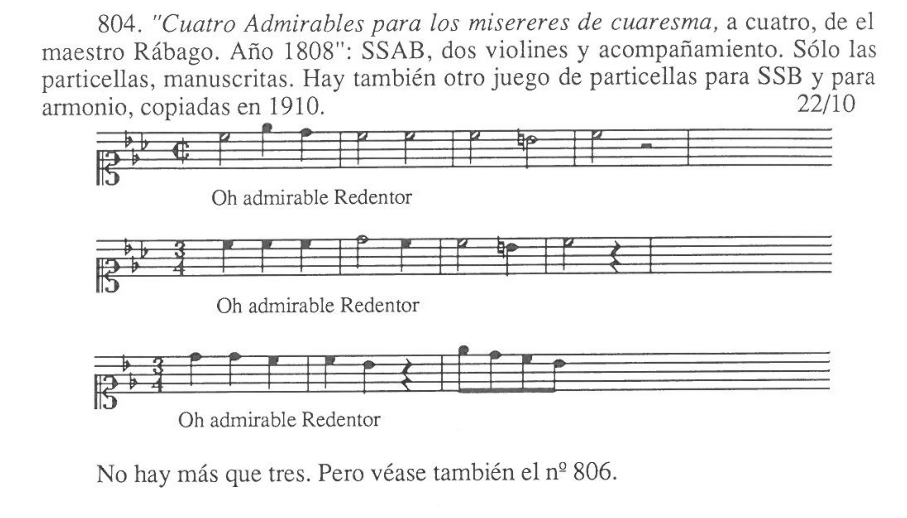

In [96]:
Obra = []
pag = 179
n = len(Obras_final['Rábago, Manuel de'][804]['Coordenadas'])
for j in range(0,n):
  x,y,w,h = Obras_final['Rábago, Manuel de'][804]['Coordenadas'][j]
  fot = cv2.imread('Fotos/pag'+str(pag+j)+'.jpg')
  fot = cv2.cvtColor(fot,cv2.COLOR_BGR2RGB)
  Obra.append(fot[y:y+h+5,x:x+w])
Obra = np.concatenate(Obra,axis=0)
mostrarImagen(Obra)

In [97]:
data = image2data(Obra,model='yolo')
print(data)

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
Cannot load image data/labels/32_0.png
Cannot load image data/labels/33_0.png
Cannot load image data/labels/34_0.png
Cannot load image data/labels/35_0.png
Cannot load image data/labels/36_0.png
Cannot load image data/labels/37_0.png
Cannot load image data/labels/38_0.png
Cannot load image data/labels/39_0.png
Cannot load image data/labels/40_0.png
Cannot load image data/labels/41_0.png
Cannot load image data/labels/42_0.png
Cannot load image data/labels/43_0.png
Cannot load image data/labels/44_0.png
Cannot load image data/labels/45_0.png
Cannot load image data/labels/46_0.png
Cannot load image data/labels/47_0.png
Cannot load image data/labels/48_0.png
Cannot load image data/labels/49_0.png
Cannot load image data/labels/50_0.png
Cannot load image data/labels/51_0.png
Cannot load image data/labels/52_0.png
Cannot load image data/labels/53_0.png
Cannot load image data/labels/5

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
Cannot load image data/labels/32_0.png
Cannot load image data/labels/33_0.png
Cannot load image data/labels/34_0.png
Cannot load image data/labels/35_0.png
Cannot load image data/labels/36_0.png
Cannot load image data/labels/37_0.png
Cannot load image data/labels/38_0.png
Cannot load image data/labels/39_0.png
Cannot load image data/labels/40_0.png
Cannot load image data/labels/41_0.png
Cannot load image data/labels/42_0.png
Cannot load image data/labels/43_0.png
Cannot load image data/labels/44_0.png
Cannot load image data/labels/45_0.png
Cannot load image data/labels/46_0.png
Cannot load image data/labels/47_0.png
Cannot load image data/labels/48_0.png
Cannot load image data/labels/49_0.png
Cannot load image data/labels/50_0.png
Cannot load image data/labels/51_0.png
Cannot load image data/labels/52_0.png
Cannot load image data/labels/53_0.png
Cannot load image data/labels/5

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
Cannot load image data/labels/32_0.png
Cannot load image data/labels/33_0.png
Cannot load image data/labels/34_0.png
Cannot load image data/labels/35_0.png
Cannot load image data/labels/36_0.png
Cannot load image data/labels/37_0.png
Cannot load image data/labels/38_0.png
Cannot load image data/labels/39_0.png
Cannot load image data/labels/40_0.png
Cannot load image data/labels/41_0.png
Cannot load image data/labels/42_0.png
Cannot load image data/labels/43_0.png
Cannot load image data/labels/44_0.png
Cannot load image data/labels/45_0.png
Cannot load image data/labels/46_0.png
Cannot load image data/labels/47_0.png
Cannot load image data/labels/48_0.png
Cannot load image data/labels/49_0.png
Cannot load image data/labels/50_0.png
Cannot load image data/labels/51_0.png
Cannot load image data/labels/52_0.png
Cannot load image data/labels/53_0.png
Cannot load image data/labels/5

{'pent_1': {'bboxs': [[0, 32, 37, 82], [33, 6, 51, 35], [41, 27, 61, 57], [53, 10, 72, 38], [93, 16, 120, 55], [145, 10, 171, 57], [198, 0, 220, 46], [245, 5, 268, 52], [293, 10, 304, 58], [313, 9, 337, 55], [369, 8, 394, 55], [428, 10, 440, 57], [448, 7, 473, 55], [508, 3, 523, 39], [517, 12, 541, 62], [576, 9, 587, 57], [595, 7, 620, 54], [657, 23, 682, 36], [713, 8, 724, 57]], 'labels': ['claved1', 'bem', 'bem', 'bem', '4x4', 'nota2_9_text:Oh admirable Redentor', 'nota1_11', 'nota1_10', 'line', 'nota2_9', 'nota2_9', 'line', 'nota2_9', 'bec', 'nota2_8_bec', 'line', 'nota2_9', 'sil2', 'line']}, 'pent_2': {'bboxs': [[0, 28, 36, 76], [32, 1, 51, 30], [41, 23, 60, 51], [53, 6, 72, 33], [92, 7, 115, 51], [149, 6, 174, 51], [197, 6, 221, 51], [245, 5, 268, 51], [293, 6, 304, 52], [312, 0, 336, 46], [366, 4, 388, 50], [414, 5, 425, 52], [433, 2, 457, 50], [483, 0, 499, 32], [494, 8, 516, 55], [541, 4, 553, 51], [561, 2, 586, 48], [620, 3, 640, 49], [668, 3, 679, 50]], 'labels': ['claved1', 

# Salto a xml
- Transforma esa lista de elementos a el formato musicxml

In [98]:
claves = {'G2':{-4:'F3', -3:'G3', -2:'A3', -1:'B3', 0:'C4', 1:'D4', 2:'E4', 3:'F4', 4:'G4', 5:'A4', 6:'B4', 7:'C5', 8:'D5', 9:'E5', 10:'F5', 11:'G5', 12:'A5', 13:'B5', 14:'C6'},
          'F4':{-4:'A1', -3:'B1', -2:'C2', -1:'D2', 0:'E2', 1:'F2', 2:'G2', 3:'A2', 4:'B2', 5:'C3', 6:'D3', 7:'E3', 8:'F3', 9:'G3', 10:'A3', 11:'B3', 12:'C4', 13:'D4', 14:'E4'},
          'C1':{-4:'D3', -3:'E3', -2:'F3', -1:'G3', 0:'A3', 1:'B3', 2:'C4', 3:'D4', 4:'E4', 5:'F4', 6:'G4', 7:'A4', 8:'B4', 9:'C5', 10:'D5', 11:'E5', 12:'F5', 13:'G5', 14:'A5'},
          'C3':{-4:'G2', -3:'A2', -2:'B2', -1:'C3', 0:'D3', 1:'E3', 2:'F3', 3:'G3', 4:'A3', 5:'B3', 6:'C4', 7:'D4', 8:'E4', 9:'F4', 10:'G4', 11:'A4', 12:'B4', 13:'C5', 14:'D5'},
          'C4':{-4:'E2', -3:'F2', -2:'G2', -1:'A2', 0:'B2', 1:'C3', 2:'D3', 3:'E3', 4:'F3', 5:'G3', 6:'A3', 7:'B3', 8:'C4', 9:'D4', 10:'E4', 11:'F4', 12:'G4', 13:'A4', 14:'B4'}}

In [99]:
nombres={'background':'background','claved1':'C1', 'claved3':'C3', 'claved4': 'C4', 'claves':'G2', 'clavef':'F4', 'nota1':'quarter', 'nota2':'half', 'nota4':'whole', 'nota1:2':'eighth', 'nota1:4':'16th', 'notae':'grace', 'sos':'sharp', 'bem':'flat', 'bec':'natural', 'sil0':'multiple-rest', 'sil1':'quarter', 'sil2':'half', 'sil1:2':'eighth', 'sil1:4':'16th', '2x4':'2x4', '3x4':'3x4', '4x4':'4x4', '6x8':'6x8', 'punt':'dot', 'liga':'beam','3':'tuplet','line':'measure','P2':'P2', 'nota1:8':'32nd', 'cal':'cal', '3x2':'3x2','mf':'mf','P1':'P1','check':'check','3x8':'3x8','2x2':'2x2'}

In [100]:
duration = {'32nd':'1','16th':'2','eighth':'4','quarter':'8','half':'16','whole':'32'}

## Funciones

In [101]:
def crear(dimension=(1000,1000),text=''):
  score_partwise = ET.Element('score-partwise')
  score_partwise.set('version','3.1')
  defaults = ET.SubElement(score_partwise,'defaults')
  scaling = ET.SubElement(defaults,'scaling')
  millimeters = ET.SubElement(scaling,'millimeters')
  millimeters.text = '4.8'
  tenths = ET.SubElement(scaling,'tenths')
  tenths.text = '40'
  page_layout = ET.SubElement(defaults,'page-layout')
  page_height = ET.SubElement(page_layout,'page-height')
  page_height.text = str(dimension[1])
  page_width = ET.SubElement(page_layout,'page-width')
  page_width.text = str(dimension[0])
  page_margins = ET.SubElement(page_layout,'page-margins')
  left_margin = ET.SubElement(page_margins,'left-margin')
  left_margin.text = '100'
  right_margin = ET.SubElement(page_margins,'right-margin')
  right_margin.text = '100'
  top_margin = ET.SubElement(page_margins,'top-margin')
  top_margin.text = '10'
  bottom_margin = ET.SubElement(page_margins,'bottom-margin')
  bottom_margin.text = '10'
  word_font = ET.SubElement(defaults,'word-font')
  word_font.set('font-family','Edwin')
  word_font.set('font-size','10')
  lyric_font = ET.SubElement(defaults,'lyric-font')
  lyric_font.set('font-family','Edwin')
  lyric_font.set('font-size','10')
  for e in text:
    score_partwise = add_texto(score_partwise,text[e]) 
  part_list = ET.SubElement(score_partwise,'part-list')
  score_part = ET.SubElement(part_list,'score-part')
  score_part.set('id','P1')
  part_name = ET.SubElement(score_part,'part-name')
  part_name.text = 'Piano'
  part_abbreviation = ET.SubElement(score_part,'part-abbreviation')
  part_abbreviation.text = 'Pno.'
  score_instrument = ET.SubElement(score_part,'score-instrument')
  score_instrument.set('id','P1-I1')
  instrument_name = ET.SubElement(score_instrument,'instrument-name')
  instrument_name.text = 'Piano'
  midi_device = ET.SubElement(score_part,'midi-device')
  midi_device.set('id','P1-I1')
  midi_device.set('port','1')
  midi_instrument = ET.SubElement(score_part,'midi-instrument')
  midi_instrument.set('id','P1-I1')
  midi_chanel = ET.SubElement(midi_instrument,'midi-chanel')
  midi_chanel.text = '1'
  midi_program = ET.SubElement(midi_instrument,'midi-program')
  midi_program.text = '1'
  volume = ET.SubElement(midi_instrument,'volume')
  volume.text = '78.7402'
  pan = ET.SubElement(midi_instrument,'pan')
  pan.text = '78.7402'
  part = ET.SubElement(score_partwise,'part')
  part.set('id','P1')
  return score_partwise

In [102]:
def add_measure(mydata,inicio=False):
  idx = [a.tag for a in mydata.getchildren()].index('part')
  part = mydata.getchildren()[idx]
  if inicio != False:
    measure = ET.SubElement(part,'measure')
    print = ET.SubElement(measure,'print')
    print.set('new-system','yes')
    system_layout = ET.SubElement(print,'system-layout')
    system_margins = ET.SubElement(system_layout,'system-margins')
    left_margin = ET.SubElement(system_margins,'left-margin')
    left_margin.text = '25.00'
    right_margin = ET.SubElement(system_margins,'right-margin')
    right_margin.text = '25.00'
    system_distance = ET.SubElement(system_layout,'system-distance')
    system_distance.text = '85'
    attributes = ET.SubElement(measure,'attributes')
    divisions = ET.SubElement(attributes,'divisions')
    divisions.text = '32'
    key = ET.SubElement(attributes,'key')
    fifths = ET.SubElement(key,'fifths')
    fifths.text = str(inicio['fifths'])
    time = ET.SubElement(attributes,'time')
    beats = ET.SubElement(time,'beats')
    beats.text = str(inicio['compas'][0])
    beat_type = ET.SubElement(time,'beat-type')
    beat_type.text = str(inicio['compas'][2])
    clef = ET.SubElement(attributes,'clef')
    sign = ET.SubElement(clef,'sign')
    sign.text = str(inicio['clef'][0])
    line = ET.SubElement(clef,'line')
    line.text = str(inicio['clef'][1])
  else:
    measure = ET.SubElement(part,'measure')
  return mydata

In [141]:
def add_note(mydata,atributos): # Falta tratar texto, ligaduras, chords, puntos, corcheas juntas, especiales y sostenidos...
  idx = [a.tag for a in mydata.getchildren()].index('part')
  part = mydata.getchildren()[idx]
  measure = part.getchildren()[-1] # Añadimos en el último pentagrama
  note = ET.SubElement(measure,'note')
  pitch = ET.SubElement(note,'pitch')
  step = ET.SubElement(pitch,'step')
  step.text = atributos['step']
  if atributos['alter'] != 0:
    alter = ET.SubElement(pitch,'alter')
    alter.text = str(atributos['alter'])
  octave = ET.SubElement(pitch,'octave')
  octave.text = atributos['octave']
  duration = ET.SubElement(note,'duration')
  duration.text = atributos['duration']
  voice = ET.SubElement(note,'voice')
  voice.text = '1'
  tipo = ET.SubElement(note,'type')
  tipo.text = atributos['type']
  if atributos['bem'] == True:
    accidental = ET.SubElement(note,'accidental')
    accidental.text = 'flat'
  if atributos['sos'] == True:
    accidental = ET.SubElement(note,'accidental')
    accidental.text = 'sharp'
  if atributos['bec'] == True:
    accidental = ET.SubElement(note,'accidental')
    accidental.text = 'natural'
  if atributos['punt'] == True:
    dot = ET.SubElement(note,'dot')
  stem = ET.SubElement(note,'stem')
  stem.text = atributos['stem']
  if atributos['text'] != '':
    lyric = ET.SubElement(note,'lyric')
    syllabic = ET.SubElement(lyric,'syllabic')
    syllabic.text = 'single'
    texto = ET.SubElement(note,'text')
    texto.text = atributos['text']
  return mydata

In [142]:
def add_rest(mydata,atributos): # Falta gestionar los puntos y ligaduras
  idx = [a.tag for a in mydata.getchildren()].index('part')
  part = mydata.getchildren()[idx]
  measure = part.getchildren()[-1] # Añadimos en el último pentagrama
  note = ET.SubElement(measure,'note')
  rest = ET.SubElement(note,'rest')
  duration = ET.SubElement(note,'duration')
  duration.text = atributos['duration']
  voice = ET.SubElement(note,'voice')
  voice.text = '1'
  tipo = ET.SubElement(note,'type')
  tipo.text = atributos['type']
  if atributos['punt'] == True:
    dot = ET.SubElement(note,'dot')
  return mydata

In [143]:
def add_texto(mydata,atributos): # Sol el texto de las descripciones
  if atributos['tipo'] == 1:
    texto = atributos['texto'].replace('\n\x0c','').split('\n')
    n = len(texto)
    for i in range(0,n):
      if i == 0: d = '100'
      else: d = '50'
      credit = ET.SubElement(mydata,'credit')
      credit.set('page','1')
      credit_type = ET.SubElement(credit,'credit-type')
      credit_type.text = 'lyricits'
      credit_words = ET.SubElement(credit,'credit-words')
      credit_words.set('default-x',d)
      credit_words.set('default-y',str(atributos['altura']-35*i))
      credit_words.set('justify','left')
      credit_words.set('valing','top')
      credit_words.set('font-size','9')
      credit_words.text = texto[i]
  else:
    pass 
  return mydata

## Ejemplo

- **Escribiendo música de forma manual**

In [148]:
import music21
%mkdir output

In [160]:
def image2xml(img,model='faster'):
  if type(img) == str: img = cv2.imread(img)
  Y,X,_=img.shape
  X,Y = int(1.05*X),int(1.05*Y)
  data = image2data(img,model=model)
  text = {e:data[e] for e in data if 'text' in e}
  pents = {e:data[e] for e in data if 'pent' in e}
  mydata  = crear((X,Y),text)
  for e in pents:
    inicio = {'fifths':0,'compas':'4x4','clef':'G2'} # Valores por defecto
    fifths = 0
    B_F = ['B','E','A','D','G','C','F']
    S_F = ['F','C','G','D','A','E','B']
    n = len(data[e]['labels'])
    for l in data[e]['labels']:
      if 'x' in l and 'nota' not in l: n = data[e]['labels'].index(l)
    if n == len(data[e]['labels']):
      L = [data[e]['labels'][i] for i in range(0,n) if data[e]['bboxs'][i][0] <= 90]
      inicio['fifths'] = -len([l for l in L if l == 'bem']) + len([l for l in L if l == 'sos'])
      fifths = inicio['fifths']
      inicio['clef'] = nombres[[l for l in L if 'clave' in l][0]]
      clave = inicio['clef']
      mydata = add_measure(mydata,inicio)
      L = [data[e]['labels'][i] for i in range(0,n) if data[e]['bboxs'][i][0] > 90]
    else:
      L = data[e]['labels'][:n+1]
      inicio['fifths'] = -len([l for l in L if l == 'bem']) + len([l for l in L if l == 'sos'])
      fifths = inicio['fifths']
      inicio['clef'] = nombres[[l for l in L if 'clave' in l][0]]
      clave = inicio['clef']
      inicio['compas'] = L[-1]
      mydata = add_measure(mydata,inicio)
      L = data[e]['labels'][n+1:]
    if fifths == 0: Tonos = []
    if fifths < 0: Tonos = B_F[:-fifths]
    if fifths > 0: Tonos = B_F[:fifths]
    for l in L:
      step_anterior = []
      if 'nota' in l:
        atributos = {'step':'C','octave':'5','type':'quarter','stem':'down','duration':'8','text':'','sos':False,'bem':False,'bec':False,'punt':False,'alter':0,'liga':False}
        altura = l[l.find('_')+1:]
        if len(altura)>2: altura = l[l.find('_')+1:][:l[l.find('_')+1:].find('_')]
        nota = claves[clave][int(altura)]
        atributos['step'] = nota[0]
        atributos['octave'] = nota[1]
        atributos['type'] = nombres[l[:l.find('_')]]
        alter = 0
        if nota[0] in Tonos:
          if fifths < 0: alter+=1
          if fifths > 0: alter+=-1
        if nota[0] in [c[0] for c in step_anterior]:
          indice = [c[0] for c in step_anterior].index(nota[0])
          valor = step_anterior[indice]
          if 'sos' in valor and alter < 1: alter+=1
          if 'bem' in valor and alter > -1: alter+=-1
          if 'bec' in valor:
            if fifths < 0 and alter < 1: alter+=1
            if fifths > 0 and alter > -1: alter+=-1 
        if int(altura) < 6: atributos['stem'] = 'up'
        else: atributos['stem'] = 'down'
        atributos['duration'] = duration[nombres[l[:l.find('_')]]]
        if 'punt' in l:
          atributos['punt'] = True
          atributos['duration'] = str(int(atributos['duration']) + int(atributos['duration'])//2)
        if 'sos' in l:
          atributos['sos'] = True
          alter+=1
          step_anterior.append(nota[0]+'bem')
        if 'bem' in l:
          atributos['bem'] = True
          alter+=-1
          step_anterior.append(nota[0]+'bem')
        if 'bec' in l:
          atributos['bec'] = True
          if fifths < 0: alter+=1
          if fifths > 0: alter+=-1
          step_anterior.append(nota[0]+'bec')
        if 'text' in l: atributos['text'] = l[l.find('text:')+5:]
        atributos['alter'] = alter
        mydata = add_note(mydata,atributos)
      if 'line' == l:
        mydata = add_measure(mydata)
        step_anterior = []
      if 'sil' in l:
        atributos = {'type':'quarter','duration':'8','punt':False}
        atributos['type'] = nombres[l]
        atributos['duration'] = duration[nombres[l]]
        if 'punt' in l:
          atributos['punt'] = True
          atributos['duration'] = str(int(atributos['duration']) + int(atributos['duration'])//2)
        mydata = add_rest(mydata,atributos)
  mydata = prettify(mydata)
  with open("output/predict.xml", "w") as myfile:
    myfile.write(mydata)
  c = music21.converter.parse('output/predict.xml')
  c.write('midi','output/predict.mid')

In [ ]:
image2xml(Obra,model='yolo')

# Transformar el xml a midi
- https://github.com/joheras/MusicaCatedralStoDomingoIER/blob/main/Notebooks/SacarM%C3%BAsica/xml2midi.ipynb

In [ ]:
fn = '/output/predict.mid'
midi_data = pretty_midi.PrettyMIDI(fn)
Fs = 22050
audio_data = midi_data.synthesize(fs=Fs)
ipd.Audio(audio_data, rate=Fs)